Many association football modelling systems make an assumption that goals arrive in randomly according to a [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution#Assumptions_and_validity). 

From Wikipedia:
"The Poisson distribution is an appropriate model if the following assumptions are true:

P1. k is the number of times an event occurs in an interval and k can take values 0, 1, 2, ....

P2. The occurrence of one event does not affect the probability that a second event will occur. That is, events occur independently.

P3. The average rate at which events occur is independent of any occurrences. For simplicity, this is usually assumed to be constant, but may in practice vary with time.

P4. Two events cannot occur at exactly the same instant; instead, at each very small sub-interval exactly one event either occurs or does not occur.


I want to examine empirically whether these assumptions hold in the case of football, and to determine how the failure of this assumptions affects predictions.

Generally the distributions of goals conform to Poisson distributions but I find evidence of 2 persistent violations of the Poisson assumptions.


1.   The 0-0 effect. Matches appear to be governed by different dynamics before and after the first goal is scored.
2.   Momentum effect. The team that scored the last goal has a higher probability of scoring next than would otherwise be the case.

Both of these effects can be easily explained behaviourally. 

Finally I examine 2 seasons in greater detail and observe how successful teams deviate from Poisson distributions.

In [ ]:
#Import libraries
import numpy as np
import pandas as pd
import sqlite3
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET
from datetime import datetime
from scipy.stats import poisson
from tqdm import tqdm_notebook as tqdm
from matplotlib import colors as mcolors
from pylab import cm
import matplotlib
from scipy.stats import kurtosis
from google.colab import drive
import os
from datetime import datetime
import pickle



In [ ]:
#!ls drive
#drive.mount('/content/gdrive')
#with sqlite3.connect('/content/gdrive/My Drive/Football/database.db') as con:
with sqlite3.connect('/content/data/database.db') as con:
    match_query = "SELECT id,league_id,season,stage,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,goal,card from Match where league_id == 1729"
    pl_matches = pd.read_sql_query(match_query, con)
    teams = pd.read_sql_query("SELECT * from Team", con)
pl_matches.head()

#!pip install football_data_api
#from football_data_api import data_fetchers
#os.environ['FOOTBALL_DATA_API'] = "1176e6f74369408ba620860834fe20eb"
#data = data_fetchers.CompetitionData()
#data.competition = 'premier league' 
pl_matches_19_20_df = pd.read_pickle('/content/data/pl_matches_19_20_df.pkl')


'My Drive'
Mounted at /content/gdrive


DatabaseError: ignored

# Functions:

In this section I define some functions for data analysis and plotting

In [ ]:
import matplotlib.pyplot as plt

def pie_plot(x_vals,ax):
  ax.pie(x_vals,autopct = "%1.0f%%",colors =sns.color_palette("rainbow",3),
      wedgeprops = {"linewidth":2,"edgecolor":"white"})
  
max_depth=4

def plot_transition_network(transitions_df,max_depth,title=''):
  n_cols = 2**(max_depth-1)
  n_rows = max_depth

  plot_indices = [list(range(0,n_cols,2)),list(range(n_cols))]
  if max_depth > 2:
    for i in range(max_depth-2,0,-1):
      l = []
      for j in range(0,len(plot_indices[0]),2):
        l = l + [int((plot_indices[0][j]+plot_indices[0][j+1])/2)]
      plot_indices = [l]+plot_indices

  fig,axs = plt.subplots(n_rows,n_cols)
  for i in axs:
    for ax in i:
      ax.set_visible(False)
      ax.set_xmargin(0)
      ax.set_ymargin(0)
  prev_layer_seq = ['']
  
  ax = axs[0][plot_indices[0][0]]
  ax.set_visible(True)
  ax.set_title('0-0')
  x_vals = transitions_df.loc['',:].values
  #x_vals = [transitions_df.loc['','Home Goal'],transitions_df.loc['','Away Goal'],transitions_df.loc['','Final Score']]
  pie_plot(x_vals,ax)

  for i in range(1,max_depth):
    this_layer_seq = []
    for s in prev_layer_seq:
      this_layer_seq=this_layer_seq+[s+'H',s+'A']
    # location of the plots
    for j,s in enumerate(this_layer_seq):
      ax = axs[i][plot_indices[i][j]]
      ax.set_visible(True)
      x_vals = transitions_df.loc[s,:].values
      #x_vals = [transitions_df.loc[s,'Home Goal'],transitions_df.loc[s,'Away Goal'],transitions_df.loc[s,'Final Score']]
      pie_plot(x_vals,ax)
      ax.set_title(s)
    prev_layer_seq = this_layer_seq
  
  fig.subplots_adjust(hspace=0,wspace=0)
  fig.subplots_adjust(left=-.5, right=1.5, top=1.5, bottom=-.5)
  fig.legend(transitions_df.columns)
  fig.show()
  





In [ ]:
def generate_table(season):
  # compile a table
  #table = pd.DataFrame(columns=['home_team_short_name','Pos','HW','HD','HL','AW','AD','AL','W','D','L','F','A','HF','HA','AF','AA','GD','Pts'])
  table = pd.DataFrame(columns=['home_team_short_name','Pos'])
  teams = list(season.home_team_short_name.unique())

  table['home_team_short_name'] = teams


  def home_points(r):
    if r.home_team_goal > r.away_team_goal:
      return 3
    elif r.home_team_goal < r.away_team_goal:
      return 0
    else:
      return 1

  def away_points(r):
    if r.home_team_goal > r.away_team_goal:
      return 0
    elif r.home_team_goal < r.away_team_goal:
      return 3
    else:
      return 1

  def result(r):
    if r.home_team_goal > r.away_team_goal:
      return 'H'
    elif r.home_team_goal < r.away_team_goal:
      return 'A'
    else:
      return 'D'


  season['home_points'] = [home_points(r[1]) for r in season.iterrows()]
  season['away_points'] = [away_points(r[1]) for r in season.iterrows()]
  season['result'] = [result(r[1]) for r in season.iterrows()]

  # Home wins
  HW = season.loc[season.result=='H',:].groupby(['home_team_short_name']).result.count()
  table = table.merge(HW,on='home_team_short_name',how='right')
  table.rename(columns={'result':'HW'},inplace=True)

  # Home loss
  HL = season.loc[season.result=='A',:].groupby(['home_team_short_name']).result.count()
  table = table.merge(HL,on='home_team_short_name',how='right')
  table.rename(columns={'result':'HL'},inplace=True)

  # Home Draw
  HD = season.loc[season.result=='D',:].groupby(['home_team_short_name']).result.count()
  table = table.merge(HD,on='home_team_short_name',how='right')
  table.rename(columns={'result':'HD'},inplace=True)

  # Away wins
  AW = season.loc[season.result=='A',:].groupby(['away_team_short_name']).result.count()
  table = table.merge(AW,left_on='home_team_short_name',right_on ='away_team_short_name', how='right')
  table.rename(columns={'result':'AW'},inplace=True)

  # Away loss
  AL = season.loc[season.result=='H',:].groupby(['away_team_short_name']).result.count()
  table = table.merge(AL,left_on='home_team_short_name',right_on ='away_team_short_name', how='right')
  table.rename(columns={'result':'AL'},inplace=True)

  # Away Draw
  AD = season.loc[season.result=='D',:].groupby(['away_team_short_name']).result.count()
  table = table.merge(AD,left_on='home_team_short_name',right_on ='away_team_short_name', how='right')
  table.rename(columns={'result':'AD'},inplace=True)


  HF = season.groupby(['home_team_short_name']).home_team_goal.sum()
  table = table.merge(HF,left_on='home_team_short_name',right_on ='home_team_short_name', how='right')
  table.rename(columns={'home_team_goal':'HF'},inplace=True)
  HA = season.groupby(['home_team_short_name']).away_team_goal.sum()
  table = table.merge(HA,left_on='home_team_short_name',right_on ='home_team_short_name', how='right')
  table.rename(columns={'away_team_goal':'HA'},inplace=True)

  AF = season.groupby(['away_team_short_name']).away_team_goal.sum()
  table = table.merge(AF,left_on='home_team_short_name',right_on ='away_team_short_name', how='right')
  table.rename(columns={'away_team_goal':'AF'},inplace=True)
  AA = season.groupby(['away_team_short_name']).home_team_goal.sum()
  table = table.merge(AA,left_on='home_team_short_name',right_on ='away_team_short_name', how='right')
  table.rename(columns={'home_team_goal':'AA'},inplace=True)
 
  table.fillna(0,inplace=True)
  table['W'] = table['HW'] + table['AW']
  table['L'] = table['HL'] + table['AL']
  table['D'] = table['HD'] + table['AD']

  table['F'] = table['HF']+table['AF']
  table['A'] = table['HA']+table['AA']
  table['GD'] = table['F'] - table['A']
  table['Pts'] = 3*table['W']+table['D']
  table.sort_values(by=['Pts','GD'],ascending=False,inplace=True)
  table['Pos'] = range(1,table.shape[0]+1)
  
  return table

In [ ]:
def generate_table(season):
  # compile a table
  #table = pd.DataFrame(columns=['home_team_short_name','Pos','HW','HD','HL','AW','AD','AL','W','D','L','F','A','HF','HA','AF','AA','GD','Pts'])
  table = pd.DataFrame(columns=['home_team_short_name','Pos'])
  teams = list(season.home_team_short_name.unique())

  table['home_team_short_name'] = teams
  table.set_index('home_team_short_name',inplace=True)


  def home_points(r):
    if r.home_team_goal > r.away_team_goal:
      return 3
    elif r.home_team_goal < r.away_team_goal:
      return 0
    else:
      return 1

  def away_points(r):
    if r.home_team_goal > r.away_team_goal:
      return 0
    elif r.home_team_goal < r.away_team_goal:
      return 3
    else:
      return 1

  def result(r):
    if r.home_team_goal > r.away_team_goal:
      return 'H'
    elif r.home_team_goal < r.away_team_goal:
      return 'A'
    else:
      return 'D'


  season['home_points'] = [home_points(r[1]) for r in season.iterrows()]
  season['away_points'] = [away_points(r[1]) for r in season.iterrows()]
  season['result'] = [result(r[1]) for r in season.iterrows()]

  HW = season.loc[season.result=='H',:].groupby(['home_team_short_name']).result.count()
  table['HW'] = HW
  HL = season.loc[season.result=='A',:].groupby(['home_team_short_name']).result.count()
  table['HL'] = HL
  HD = season.loc[season.result=='D',:].groupby(['home_team_short_name']).result.count()
  table['HD'] = HD

  AW = season.loc[season.result=='A',:].groupby(['away_team_short_name']).result.count()
  table['AW'] = AW
  AL = season.loc[season.result=='H',:].groupby(['away_team_short_name']).result.count()
  table['AL'] = AL
  AD = season.loc[season.result=='D',:].groupby(['away_team_short_name']).result.count()
  table['AD'] = AD

  HF = season.groupby(['home_team_short_name']).home_team_goal.sum()
  table['HF'] = HF
  HA = season.groupby(['home_team_short_name']).away_team_goal.sum()
  table['HA'] = HA

  AF = season.groupby(['away_team_short_name']).away_team_goal.sum()
  table['AF'] = AF
  AA = season.groupby(['away_team_short_name']).home_team_goal.sum()
  table['AA'] = AA
  table.fillna(0,inplace=True)
  table['W'] = table['HW'] + table['AW']
  table['L'] = table['HL'] + table['AL']
  table['D'] = table['HD'] + table['AD']

  table['F'] = table['HF']+table['AF']
  table['A'] = table['HA']+table['AA']
  table['GD'] = table['F'] - table['A']
  table['Pts'] = 3*table['W']+table['D']
  table.sort_values(by=['Pts','GD'],ascending=False,inplace=True)
  table['Pos'] = range(1,table.shape[0]+1)
  table.index.name = 'Team'
  return table

In [ ]:
def simulate_random_season(table):
  matches = pd.DataFrame(columns=['home_team_short_name','away_team_short_name','home_team_goal','away_team_goal'])
  row_count = 0
  teams = table.index.values
  for home_team in teams:
    for away_team in teams:
      if home_team != away_team: # teams don't play themselves
        home_gfpg = table.loc[home_team,'HF']/(table.shape[0]-1)
        home_gapg = table.loc[home_team,'HA']/(table.shape[0]-1)
        away_gfpg = table.loc[away_team,'AF']/(table.shape[0]-1)
        away_gapg = table.loc[away_team,'AA']/(table.shape[0]-1)
        avg_away_gfpg = np.mean(table.loc[teams[teams != home_team],'AF'])/(table.shape[0]-1)
        avg_away_gapg = np.mean(table.loc[teams[teams != home_team],'AA'])/(table.shape[0]-1)
        # xG - simple formula
        # home_xgpg = home_gfpg /(sum_{all other teams} away_gapg) *away_gapg
        xG_H =  home_gfpg * away_gapg/avg_away_gapg
        xG_A =  home_gapg * away_gfpg/avg_away_gfpg
        G_H = np.random.poisson(lam=xG_H)
        G_A = np.random.poisson(lam=xG_A)
        matches.loc[row_count,:] = [home_team,away_team,G_H,G_A]
        row_count = row_count + 1
  return matches

def monte_carlo_simulate_season(table,no_scenarios):
  np.random.seed(123456)
  all_matches = simulate_random_season(table)
  all_matches['season'] = 'season_0'
  tables = [generate_table(all_matches)]
  for i in tqdm(range(1,no_scenarios)):
    matches = simulate_random_season(table)
    matches['season'] = 'season_'+str(i)
    tables.append(generate_table(matches))
    all_matches = all_matches.append(matches)

  return all_matches, tables


In [ ]:
def goal_sequence_from_xml(xml_str,team_dict):
  root = ET.fromstring(xml_str)
  score_sequence =''
  score_times = []
  for r in root:
    tags = np.array([child.tag for child in r])
    
    if 'del' in tags:
      delete = True
    else:
      delete = False

    if 'goal_type' in tags:
      goal_type = r[np.where(tags=='goal_type')[0][0]].text
    else:
      goal_type = 'n'

    if 'comment' in tags:
      comment = r[np.where(tags=='comment')[0][0]].text
    if comment == 'dg':
      goal_type = 'dg'

    if (goal_type in ('dg','npm','psm','rp')) or (delete == True):
      # disallowed goal
      pass
    else:
      # find the team and elapsed field
      if 'team'in tags:
        team_id = int(r[np.where(tags=='team')[0][0]].text)
        goal_scored_by = team_dict[team_id]
        if (goal_type == 'o'):
          if goal_scored_by == 'A':
            goal_scored_by = 'H'
          elif goal_scored_by == 'H':
            goal_scored_by = 'A'
        score_sequence = score_sequence+goal_scored_by
      else:
        score_sequence = score_sequence+'U'
      time_index = np.where(tags=='elapsed')[0][0]
      score_times.append(int(r[time_index].text))
                 
  # remove disallowed goals
  score_sequence = score_sequence.replace('D','')
  score_times = np.array(score_times)
  score_times = score_times[np.isnan(score_times)==False]

  return score_sequence, score_times

def cards_from_xml(xml_str,team_dict):
  # no home team red cards, no away team red cards
  red_cards = [0,0]
  root = ET.fromstring(xml_str)
  for c in root:
    tags = np.array([sc.tag for sc in c])
    if 'del' in tags:
      pass
    else:
      if c[np.where(tags=='comment')[0][0]].text in ('r','y2'):
        if team_dict[int(c[np.where(tags=='team')[0][0]].text)] == 'H':
          red_cards[0] = red_cards[0]+1 
        if team_dict[int(c[np.where(tags=='team')[0][0]].text)] == 'A':
          red_cards[1] = red_cards[1]+1 
  return red_cards

def extract_match_details(matches):
  score_sequence_list = []
  score_time_list = []
  sanity_list = []
  red_cards = []
  for r in matches.iterrows():  
    team_dict = {r[1].home_team_api_id:'H',r[1].away_team_api_id:'A'}
    score_sequence, score_times = goal_sequence_from_xml(r[1].goal,team_dict)
    if score_sequence.find('U') > -1:
      if r[1].home_team_goal != score_sequence.count('H'):
        score_sequence = score_sequence.replace('U','H')
      elif r[1].away_team_goal != score_sequence.count('A'):
        score_sequence = score_sequence.replace('U','A')
      else:
         score_sequence = score_sequence.replace('U','')
    
    red_cards.append(cards_from_xml(r[1].card,team_dict))
    
    # sanity checks
    sanity = True
    if len(score_sequence) != score_times.shape[0]:
      sanity = False
    if r[1].home_team_goal != score_sequence.count('H'):
      sanity = False
    if r[1].away_team_goal != score_sequence.count('A'):
      sanity = False

    score_sequence_list.append(score_sequence)
    score_time_list.append(score_times)
    sanity_list.append(sanity)

  matches['goal_times'] = score_time_list
  matches['goal_sequence'] = score_sequence_list
  matches['sanity'] = sanity_list
  matches['total_goals'] = pl_matches['home_team_goal'] + pl_matches['away_team_goal']
  matches['red_cards'] = red_cards

  #return score_sequence_list, score_time_list, sanity_list
  return matches


In [ ]:
def calculate_delta_poisson(matches,team_short):
  max_goals = max(matches.home_team_goal.max(),matches.away_team_goal.max())

  home_gf = pl_matches_19_20_df.loc[pl_matches_19_20_df.home_team_short_name==team_short,'home_team_goal'].values
  away_gf = pl_matches_19_20_df.loc[pl_matches_19_20_df.away_team_short_name==team_short,'away_team_goal'].values
  home_ga = pl_matches_19_20_df.loc[pl_matches_19_20_df.home_team_short_name==team_short,'away_team_goal'].values
  away_ga = pl_matches_19_20_df.loc[pl_matches_19_20_df.away_team_short_name==team_short,'home_team_goal'].values
  gf,gf_c = np.unique(np.array(list(home_gf)+list(away_gf)),return_counts=True)
  gfpg = np.mean(np.array(list(home_gf)+list(away_gf)))
  ga,ga_c = np.unique(np.array(list(home_ga)+list(away_ga)),return_counts=True)
  gapg = np.mean(np.array(list(home_ga)+list(away_ga)))

  poisson_dist_for=[poisson.cdf(0,gfpg)]
  poisson_dist_against=[poisson.cdf(0,gapg)]
  for i in range(1,max_goals+1):
    poisson_dist_for.append(poisson.cdf(i,gfpg)- poisson.cdf(i-1,gfpg))
    poisson_dist_against.append(poisson.cdf(i,gapg)- poisson.cdf(i-1,gapg))
  poisson_dist_for = np.array(poisson_dist_for);poisson_dist_against = np.array(poisson_dist_against)
  

  gf_c = list(gf_c);ga_c = list(ga_c)
  actual_dist_for = np.zeros([max_goals+1]);actual_dist_against = np.zeros([max_goals+1])
  for i,s in enumerate(gf):
    actual_dist_for[s] = gf_c[i]
  for i,s in enumerate(ga):
    actual_dist_against[s] = ga_c[i]
  actual_dist_for = actual_dist_for/sum(actual_dist_for)
  actual_dist_against = actual_dist_against/sum(actual_dist_against)

  return actual_dist_for, actual_dist_against, poisson_dist_for, poisson_dist_against

In [ ]:
def spines_off(ax):
  for edge, spine in ax.spines.items():
    spine.set_visible(False)
  return ax

def heatmap_with_histograms(mat,dist_h,dist_v,cmap,xlab,ylab,pltscale=1):

  my_cmap = cm.get_cmap(cmap, 5)    # PiYG
  clist = []
  for i in range(my_cmap.N):
    rgb = my_cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    clist.append((i/(my_cmap.N-1),mcolors.rgb2hex(rgb)))
  
  rvb = mcolors.LinearSegmentedColormap.from_list("", clist)  
  
  fig_size = (pltscale*dist_h.shape[0],pltscale*dist_v.shape[0])
  fig = plt.figure(constrained_layout=True,figsize=fig_size)
  #fig.tight_layout(0,0)
  widths = [4, .5]
  heights = [.5, 4]
  spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths,
                            height_ratios=heights)

  # heatmap 
  ax = fig.add_subplot(spec[1, 0])
  im = ax.imshow(mat,cmap=cmap)
  ax.set_xticks(np.arange(mat.shape[1]+1)-.5, minor=True)
  ax.set_yticks(np.arange(mat.shape[0]+1)-.5, minor=True)
  ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
  ax.tick_params(which="minor", bottom=False, left=False)
  ax = spines_off(ax)
  plt.xlabel(xlab)
  plt.ylabel(ylab)
  ax.tick_params(top=True, bottom=False,labeltop=True, labelbottom=False,
                right=True,left=False,labelleft=False, labelright = True)
  #ax.margins(x=0,y=0)
  formater = matplotlib.ticker.StrMethodFormatter("{x:.1f}%")
  font = dict(horizontalalignment="center",verticalalignment="center")
  for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
      text = im.axes.text(j, i, formater(mat[i, j]*100, None),fontdict=font)
  
  # horizontal histogram
  ax = fig.add_subplot(spec[0, 0])
  ax.bar(np.arange(dist_h.shape[0]),dist_h,color=rvb(dist_h)) 
  ax.margins(x=0.04167,y=0.0)
  plt.xticks([],visible=False);plt.yticks([],visible=False);ax = spines_off(ax)
  prop1 = ax.properties() 
  # vertical histogram
  ax = fig.add_subplot(spec[1, 1])
  plt.xticks()
  plt.xticks([],visible=False);plt.yticks([],visible=False)
  ax.barh(np.arange(dist_v.shape[0]),np.flip(dist_v),color=rvb(dist_v));ax = spines_off(ax)
  ax.margins(x=0,y=0.020835)


# Violations of the Poisson assumptions

First of all I put all the data into the format I need.

In [ ]:
# Here i am just extracting the data I need for the below analysis
league_id = 1729 #england premier league
team_short = teams.loc[:,['team_api_id','team_short_name']] 
pl_matches = pd.merge(left=pl_matches,right=team_short,left_on='home_team_api_id',right_on='team_api_id')
pl_matches.rename(columns={'team_short_name':'home_team_short_name'},inplace=True)
pl_matches.drop(columns=['team_api_id'],inplace=True)
pl_matches = pd.merge(left=pl_matches,right=team_short,left_on='away_team_api_id',right_on='team_api_id')
pl_matches.rename(columns={'team_short_name':'away_team_short_name'},inplace=True)
pl_matches.drop(columns=['team_api_id'],inplace=True)

pl_matches = extract_match_details(pl_matches)
np.where(pl_matches.sanity==False)
# correct a couple of errors
pl_matches.loc[1405,'goal_sequence'] = 'AHA'
pl_matches.loc[2570,'goal_sequence'] = 'AHHHH'
pl_matches.columns

In [ ]:
# the 2019-2020 table comes from a different data source
date_today = datetime.today()
pl_matches_19_20 = data.get_info('matches',dateFrom='2019-08-01', dateTo='2020-07-31')

pl_matches_19_20_df = pd.DataFrame(columns=['season','Matchweek','date','home_team_goal','away_team_goal','total_goals'])
for i,m in enumerate(pl_matches_19_20['matches']):
  pl_matches_19_20_df.loc[i,'season'] = m['season']['startDate'][2:4]+'/'+m['season']['endDate'][2:4]
  pl_matches_19_20_df.loc[i,'Matchweek'] = m['matchday']
  pl_matches_19_20_df.loc[i,'date'] = m['lastUpdated']
  pl_matches_19_20_df.loc[i,'HomeTeam'] = m['homeTeam']['name']
  pl_matches_19_20_df.loc[i,'AwayTeam'] = m['awayTeam']['name']
  pl_matches_19_20_df.loc[i,'home_team_goal'] = m['score']['fullTime']['homeTeam']
  pl_matches_19_20_df.loc[i,'away_team_goal'] = m['score']['fullTime']['awayTeam']
  pl_matches_19_20_df.loc[i,'total_goals'] = pl_matches_19_20_df.loc[i,'home_team_goal'] + pl_matches_19_20_df.loc[i,'away_team_goal']

long_name = pl_matches_19_20_df.HomeTeam.unique()
short_code  =['LIV','WHU','BUR','CRY','WAT','BOU','TOT','LEI','NEW','MUN','ARS','AVL','EVE','NOR','SOU','BHA','MCI','SHU','CHE','WLV']
short_code_dict = dict(zip(list(long_name),list(short_code)))
for i in range(pl_matches_19_20_df.shape[0]):
  pl_matches_19_20_df.loc[i,'home_team_short_name'] = short_code_dict[pl_matches_19_20_df.loc[i,'HomeTeam']]
  pl_matches_19_20_df.loc[i,'away_team_short_name'] = short_code_dict[pl_matches_19_20_df.loc[i,'AwayTeam']]

pl_matches_19_20_df.to_pickle('pl_matches_19_20_df.pkl')

First I look at goal scoring sequences and their impact on outcomes. I look at the entire dataset of matches (2008-2016) and count the occurences of sequence of goals. Using H to denote home goals and A to denote away goals, the code AHH represent a match in which the away team scored first, followed by 2 goals for the away team.

In [ ]:
# transition probabilities

a = pl_matches.goal_sequence.value_counts()
all_seq = a.index.values
transitions_counts = np.zeros([len(all_seq),3])
pd.DataFrame(index=a.index,columns=['Home Goal','Away Goal','Final Score'])
seq = ''
for i,seq in enumerate(all_seq):
  hg_seq = seq+'H'
  ag_seq = seq+'A'
  idx_hg = [a[:len(hg_seq)]==hg_seq for a in all_seq]
  idx_ag = [a[:len(ag_seq)]==ag_seq for a in all_seq]
  home_goal_count = np.sum(a[idx_hg].values)
  away_goal_count = np.sum(a[idx_ag].values)
  final_score_count = a[i]
  total_count = home_goal_count + away_goal_count + final_score_count
  transitions_counts[i,:] = [home_goal_count/total_count,away_goal_count/total_count,final_score_count/total_count]

transitions_df =pd.DataFrame(index=a.index,columns=['Home Goal','Away Goal','Final Score'],data=transitions_counts)

plot_transition_network(transitions_df,max_depth)


Each chart shows the empirical probability of the next scoring event (home goal/away goal/match ends with no furthe scores) for all matches in our dataset that follow the given scoring sequence so far. 

For example the pie labelled 'HA' looks at all matches in which the first goal was scored by the home team and the second was an equalizer from the away team. In 38% of those matches, the home team score next, the away team scored next in 32% and the remaining examples finished 1-1.

One thing to note is that the sequence of goals is important. Compare 'HHA' to 'AHH'. In both cases the current score is 2-1, however the respective probabilites that the away teams scores next are 31% and 21%.

We have modelled all the matches according to average home and away goals per game for the entire dataset of matches. If we assume that each match is governed by a pair of Poisson processes with match specific goal scoring rates then the fact that the above probabilities change after each goal can be explained by an application of Bayes theorem.  
However the "momentum" effect is definitely not consistent with this assumption. The order in which goals are scored shoud have no impact on what happens next. 

Some of this can possibly be explained by events such at red cards that fundamentally alter the match dynamics. Below I plot the same data considering only matches with 0 red cards.


In [ ]:
# transition probabilities
pl_matches_res = pl_matches.loc[np.array([c[0]+c[1] for c in pl_matches.red_cards])==0,:]
a = pl_matches_res.goal_sequence.value_counts()
all_seq = a.index.values
transitions_counts = np.zeros([len(all_seq),3])
pd.DataFrame(index=a.index,columns=['Home Goal','Away Goal','Final Score'])
seq = ''
for i,seq in enumerate(all_seq):
  hg_seq = seq+'H'
  ag_seq = seq+'A'
  idx_hg = [a[:len(hg_seq)]==hg_seq for a in all_seq]
  idx_ag = [a[:len(ag_seq)]==ag_seq for a in all_seq]
  home_goal_count = np.sum(a[idx_hg].values)
  away_goal_count = np.sum(a[idx_ag].values)
  final_score_count = a[i]
  total_count = home_goal_count + away_goal_count + final_score_count
  transitions_counts[i,:] = [home_goal_count/total_count,away_goal_count/total_count,final_score_count/total_count]

transitions_df =pd.DataFrame(index=a.index,columns=['Home Goal','Away Goal','Final Score'],data=transitions_counts)

plot_transition_network(transitions_df,max_depth)


Next consider goals per minute - I consider time the rate at which goals are scored, then compare it to the rate at which goals are scored after the first goal. To make it a fair comparison, I include only matches in which at least one goal is scored in the analysis.

In [ ]:
pl_matches_res = pl_matches.loc[pl_matches.total_goals>0,:]
n_matches = pl_matches_res.shape[0]
first_goal_times = [g[0] for g in pl_matches_res.goal_times]
all_goal_times = []
[[all_goal_times.append(g) for g in goal_times] for goal_times in pl_matches_res.goal_times]
t_all, goal_counts = np.unique(all_goal_times,return_counts=True)
# normalze by number of matches to get the rate
goal_counts = goal_counts/n_matches

# now all goals after the first goal
subsequent_goal_times = []
[[subsequent_goal_times.append(g-goal_times[0]) for g in goal_times[1:]] for goal_times in pl_matches_res.goal_times]
# we normalize by the number of matches still playing...
# because the matches 'start' at different times, they last for different lengths of time
# so for all numbers t up to 90 we count the number of matches that are still being
# played t minutes after the first goal
# ie take first goal time, subtract from 90 and 
time_left_after_first_goal = 90- np.array(first_goal_times)
n_matches = [sum(time_left_after_first_goal>=t) for t in range(90)]

t_s, subsequent_goal_counts = np.unique(subsequent_goal_times,return_counts=True)
subsequent_goal_counts = subsequent_goal_counts/n_matches

plt.figure(figsize=(16,6))
plt.subplot(121)
plt.plot(t_all,(goal_counts))
plt.plot(t_all,(subsequent_goal_counts))
plt.ylabel('Goals per minute')
plt.xlabel('Time (minutes)')
plt.legend(('All goals','Goals after first goal'))

plt.subplot(122)
plt.plot(t_all,np.cumsum(goal_counts))
plt.plot(t_all,np.cumsum(subsequent_goal_counts))
plt.xlabel('Time (minutes)')
plt.legend(('All goals','Goals after first goal'))
plt.ylabel('Cumulative goals')
plt.show()


The charts demonstrate that the rate at which goals are scored clearly 
increases after the first goal, a violation of the P2 and P3. Next I look at the overall distribution of goals (considering away goals and home goals as different processes) to see if the conform to the Poisson distribution.

The spike in the blue line at 45 minutes represents the fact that goals scored in injury time at the end of the first half are all recorded in this analysis as having been score in the 45th minute. Since injury time in the first half is typically 1 or 2 minutes we should expect about 2 or 3 times as many goal in that interval. We see a similar (but large spike at full time). 

For the orange series, we count time from when the first goal was scored, so half time happens at different times in every match in the dataset, so there is no equivalent half time spike. However the cumulative graph on the right demonstrates that this anomaly does not account for the discrepancy between the 2 series. 

In [ ]:
# first I find the empirical distribution for the 8 seasons in my dataset
home_goals = []
away_goals = []
for m in pl_matches.iterrows():
  home_goals.append(m[1].home_team_goal)
  away_goals.append(m[1].away_team_goal)

no_matches = pl_matches.shape[0]
hg,hg_c = np.unique(home_goals,return_counts=True); hg_c = hg_c/sum(hg_c)
ag,ag_c = np.unique(away_goals,return_counts=True); ag_c = ag_c/sum(ag_c)
max_goals = max(pl_matches.home_team_goal.max(),pl_matches.away_team_goal.max())
hg_dist = np.zeros(max_goals+1);ag_dist = np.zeros(max_goals+1)
for i,s in enumerate(hg):
  hg_dist[s] = hg_c[i]
for i,s in enumerate(ag):
  ag_dist[s] = ag_c[i]

h_gpg = np.sum(home_goals)/no_matches 
a_gpg = np.sum(away_goals)/no_matches 

# the poisson distribution of goals based on the goals per game of home and away teams
max_goals = max(np.max(hg),np.max(ag))
poisson_dist_hg = [poisson.pmf(i,h_gpg) for i in range(0,max_goals+1)]
poisson_dist_ag = [poisson.pmf(i,a_gpg) for i in range(0,max_goals+1)]
plt.figure(figsize=(12,4))
plt.subplot(121)
x = np.arange(max_goals+1)
plt.bar(x-0.4, poisson_dist_hg, width=0.4, align='center',edgecolor = "k",linewidth =2)
plt.bar(x, hg_dist, width=0.4, align='center',edgecolor = "k",linewidth =2)
plt.ylim((0,.4));plt.xticks(range(max_goals+1));plt.xlabel('No. goals');plt.title('Home Goals')
plt.legend(('Poisson distribution','Empirical distribution'))

plt.subplot(122)
x = np.arange(max_goals+1)
plt.bar(x-0.4, poisson_dist_ag, width=0.4,  align='center',edgecolor = "k",linewidth =2)
plt.bar(x, ag_dist, width=0.4,  align='center',edgecolor = "k",linewidth =2)
plt.ylim((0,.4));plt.xticks(range(max_goals+1));plt.xlabel('No. goals');plt.title('Away Goals')
plt.legend(('Poisson distribution','Empirical distribution'));


In both the case of home and away goals, the emprical frequency of zeros goals exceeds the theoretical frequency. This could be a consequence of the fact observed above that the first goal of the game irrevocably alters the scoring probabilites - as if one process governs goal scoring when the match is 0-0, but another process takes over once a goal is scored. Behaviourally this is intuitive - a team which takes a conservative approach at 0-0 has nothing to lose once they fall behind and may attack more freely and take more risk defensively, increasing the probability of goals at both ends of the pitch.
If so, this is a violation of P2. 

In [ ]:
max_goals = 6
lambda_a=pl_matches.away_team_goal.sum()/pl_matches.shape[0]
lambda_h=pl_matches.home_team_goal.sum()/pl_matches.shape[0]
dist_h = np.array([poisson.pmf(i,lambda_h) for i in range(max_goals+1)])
dist_a = np.array([poisson.pmf(i,lambda_a) for i in range(max_goals+1)])
mat = np.outer(dist_h,dist_a)
heatmap_with_histograms(mat,dist_h,dist_a,'PuBuGn',
                        'Home Goals','Away Goals')




Theoretical distribution of results, given the rate of home and away goals per game.

In [ ]:
# the empirical dist
result_freq = pl_matches.groupby(['home_team_goal','away_team_goal']).id.count().unstack()/pl_matches.shape[0]
result_freq = result_freq.iloc[:max_goals+1,:max_goals+1]
result_freq.fillna(0,inplace=True)
result_freq.values
heatmap_with_histograms(result_freq.values,hg_c[:max_goals+1],ag_c[:max_goals+1],'PuBuGn',
                        'Home Goals','Away Goals')

The actual distribution of results (2008-2016).

In [ ]:
# the difference
heatmap_with_histograms(result_freq.values-mat,hg_c[:max_goals+1]-dist_h,ag_c[:max_goals+1]-dist_a,'PuBuGn',
                        'Home Goals','Away Goals')

This chart shows the differences of previous 2 tables. The theoretical distribution underestimates 0-0 draws and overestimates 1-1 draws. The former can be attributed to the observation above that the match dynamics change after the first goal while the latter may be explained by the momentum effect noted above.

# 2015/2016 season

Now I will compare the outcome of full seasons modelled using a Poisson distribution for goals and compare them to the actual outcome.

Let's start with the remarkable 2015/2016 season.

In [ ]:
season = '2015/2016'
pl_season_15_16 = pl_matches.loc[pl_matches.season==season,:]
actual_table_15_16 = generate_table(pl_season_15_16)
print(actual_table_15_16)


Against all odds Leicester City went from narrowly avoiding relgation in 2014/2015 to runaway champions 12 months later - reportedly some bookmakers offered odds 5000-1 against them at the start of the season. Leicester's outperformance relative to xG and xGA that season is well documented but here I want to see how a Poisson monte-carlo modelling approach would have performed with perfect foresight of the total number of home and away goals each team would score and concede over the season.

Lets simulate the season 1,000 times, using each team's home goals per game (H_GPG) and away goal per game (A_GPG) as the inputs into independent Poisson processes.

In [ ]:
run_mc_sim_15_16 = False
if run_mc_sim_15_16:
  n_scenarios = 1000
  all_matches_15_16, all_tables_15_16 = monte_carlo_simulate_season(actual_table_15_16,n_scenarios)
  full_table_15_16 = round(generate_table(all_matches_15_16)/n_scenarios,1)
  full_table_15_16.Pos = range(1,21)
  print(full_table_15_16)
  all_matches_15_16.to_pickle('mc_matches_15_16.pkl')
  pickle.dump(all_tables_15_16, open( "mc_tables_15_16.pkl", "wb" ) )
else:
  all_matches_15_16 = pd.read_pickle("/content/data/mc_matches_15_16.pkl")
  all_tables_15_16 = pickle.load( open( "/content/data/mc_tables_15_16.pkl", "rb" ) )


With the output of this model we can already do a lot. For example, for each team we can count in what percentage of scenarios they won the league.

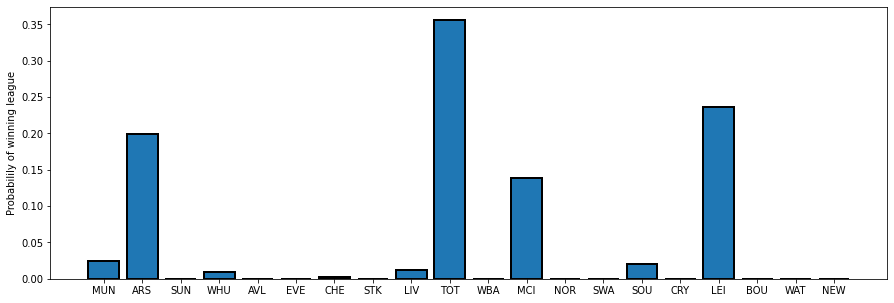

In [ ]:
teams = pl_season_15_16.home_team_short_name.unique()
winner_dist = np.array([np.sum(np.array([t.loc[team,'Pos'] for t in all_tables_15_16])==1) for team in teams])/n_scenarios
plt.figure(figsize=(15,5))
plt.bar(teams,winner_dist,edgecolor = "k",linewidth =2);plt.ylabel('Probabilily of winning league')
plt.show()


For each team we can find a distribution of their final standing. In each case the red bar represents where the  team actually finished. We can see that in most cases the model did a reasonable job.

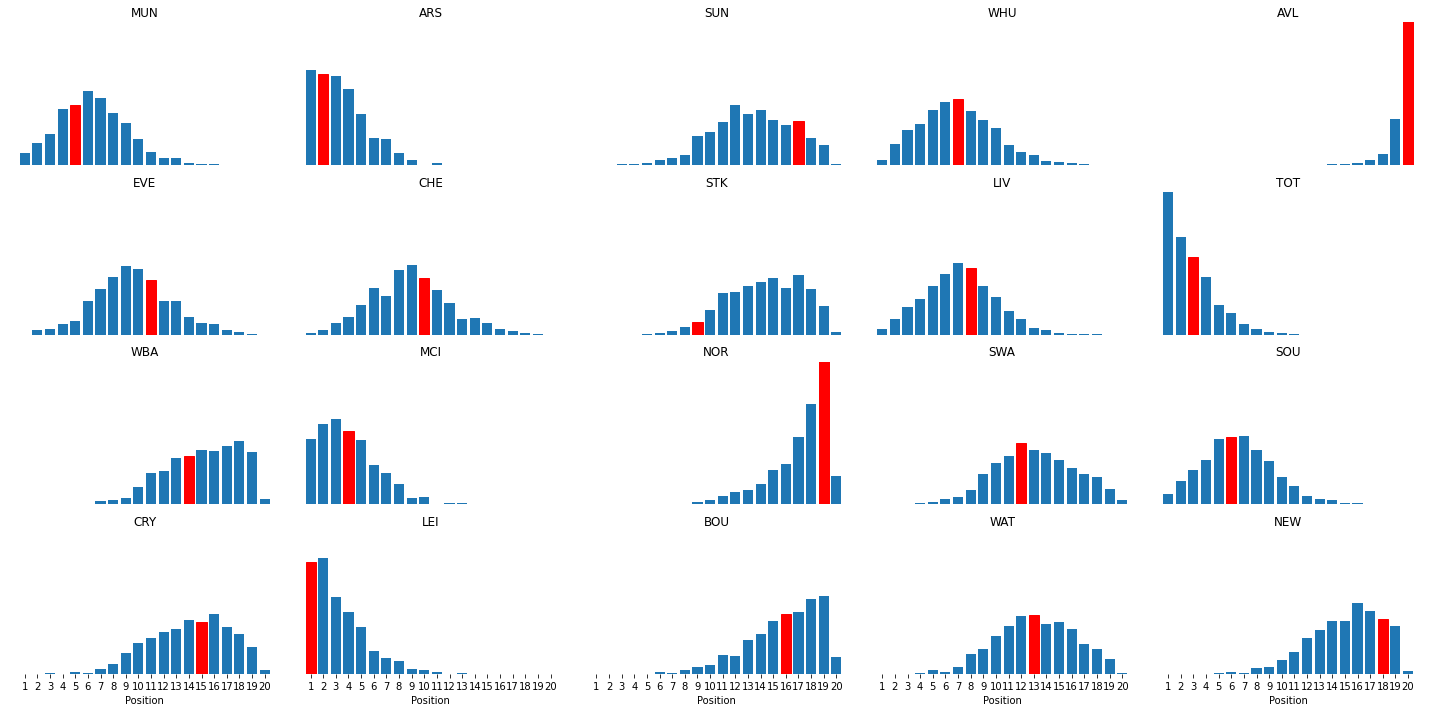

In [ ]:
pos_dist = [[sum([(t.loc[team,'Pos']==p) for t in all_tables_15_16])/n_scenarios for p in range(1,21)] for team in teams]
plt.figure(figsize=(20,10))
for i,team in enumerate(teams):
  ax = plt.subplot(4,5,i+1)
  barlist = plt.bar(range(1,21),pos_dist[np.where(np.array(teams)==team)[0][0]])
  barlist[actual_table_15_16.loc[team,'Pos']-1].set_color('r')  
  plt.xlabel("");plt.ylabel("");plt.title(team,loc='center');plt.yticks([],visible=False);
  plt.ylim([0,.300])
  if i < 15:
    plt.xticks([],visible=False)
  else:
    plt.xticks(range(1,21))
    plt.xlabel('Position')
  ax.spines['left'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['bottom'].set_visible(False)

plt.tight_layout()
plt.show()


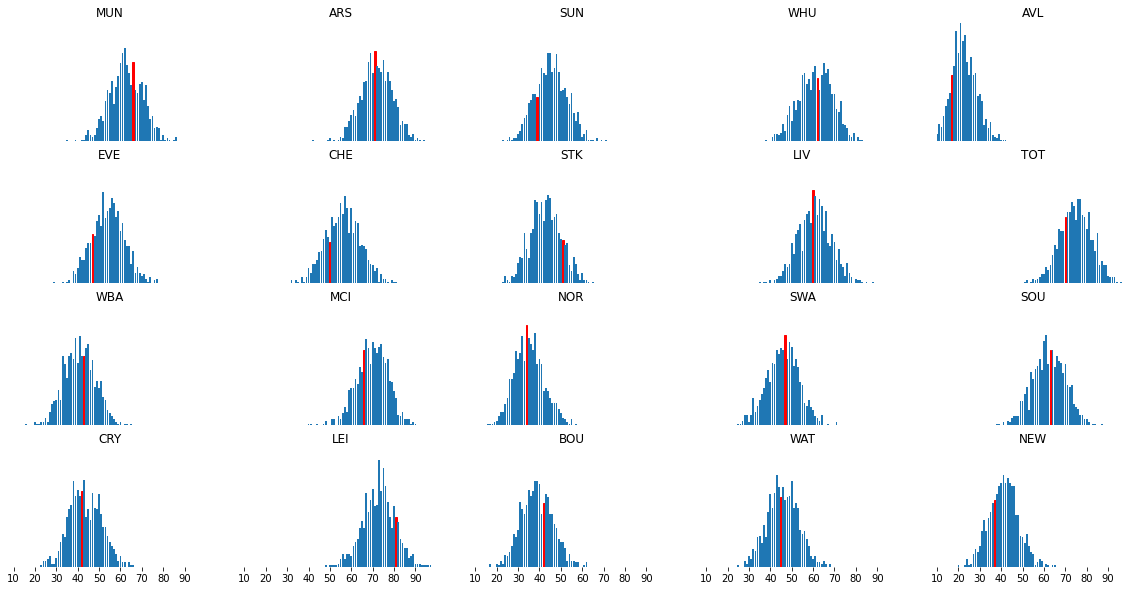

In [ ]:
plt.figure(figsize=(20,10))
for i,team in enumerate(teams):
  ax = plt.subplot(4,5,i+1)
  p,c = np.unique([t.loc[team,'Pts'] for t in all_tables_15_16],return_counts=True)
  #plt.xticks(range(1,21))
  barlist = plt.bar(p,c/n_scenarios)  
  barlist[np.argmin(np.abs(p-actual_table_15_16.loc[team,'Pts']))].set_color('r')  
  plt.xlabel("");plt.ylabel("");plt.title(team,loc='center');plt.yticks([],visible=False)#
  if i < 15:
    plt.xticks([],visible=False)
  else:
    plt.xticks(range(10,100,10))
  plt.ylim([0,.08])
  plt.xlim([10,100])
  ax.spines['left'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['bottom'].set_visible(False)

plt.show()


While Leicester City's position and, in particular, points total are both at the upper range of the distribution, the probabilities of both occurrences are reasonable.
Of course the team that finishes top in any given season could be expected to outperform their expected position, so the above gives us little insight into their remarkable season - consider that if Leicester had finished in the expected (according to this model) 2nd or 3rd position, it would still have been considered an unprecedented achievement for a club with their resources.

# 2019/2020 season

Now lets analyse the 19/20 season. Liverpool's achievement in improving on the previous season's 97 point haul is worth a closer look, but also Manchester City's record of losing almost a quarter of their matches while recording a goal difference of +67.

In [ ]:
season = '2019/2020'
actual_table_19_20 = generate_table(pl_matches_19_20_df)
print(actual_table_19_20)

      Pos  HW    HL  HD  AW  AL  AD  HF  ...  AA   W     L   D    F   A  GD  Pts
Team                                     ...                                    
LIV     1  18   0.0   1  14   3   2  52  ...  17  32   3.0   3   85  33  52   99
MCI     2  15   2.0   2  11   7   1  57  ...  22  26   9.0   3  102  35  67   81
MUN     3  10   2.0   7   8   6   5  40  ...  19  18   8.0  12   66  36  30   66
CHE     4  11   5.0   3   9   7   3  30  ...  38  20  12.0   6   69  54  15   66
LEI     5  11   4.0   4   7   8   4  35  ...  24  18  12.0   8   67  41  26   62
TOT     6  12   4.0   3   4   7   8  36  ...  30  16  11.0  11   61  47  14   59
WLV     7   8   4.0   7   7   5   7  27  ...  21  15   9.0  14   51  40  11   59
ARS     8  10   3.0   6   4   7   8  36  ...  24  14  10.0  14   56  48   8   56
SHU     9  10   6.0   3   4   6   9  24  ...  24  14  12.0  12   39  39   0   54
BUR    10   8   7.0   4   7   7   5  24  ...  27  15  14.0   9   43  50  -7   54
SOU    11   6  10.0   3   9 

In [ ]:
run_mc_sim_19_20 = False
if run_mc_sim_19_20:
  n_scenarios = 1000
  all_matches_19_20, all_tables_19_20 = monte_carlo_simulate_season(actual_table_19_20,n_scenarios)
  full_table_19_20 = round(generate_table(all_matches_19_20)/n_scenarios,1)
  full_table_19_20.Pos = range(1,21)
  print(full_table_19_20)
  all_matches_19_20.to_pickle('mc_matches_19_20.pkl')
  pickle.dump(all_tables_19_20, open( "mc_tables_19_20.pkl", "wb" ) )
else:
  all_matches_19_20 = pd.read_pickle("/content/data/mc_matches_19_20.pkl")
  all_tables_19_20 = pickle.load( open( "/content/data/mc_tables_19_20.pkl", "rb" ) )



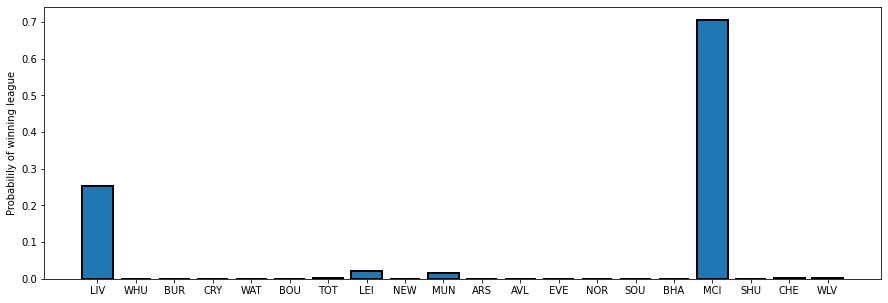

In [ ]:
teams = pl_matches_19_20_df.home_team_short_name.unique()
winner_dist = np.array([np.sum(np.array([t.loc[team,'Pos'] for t in all_tables_19_20])==1) for team in teams])/n_scenarios
plt.figure(figsize=(15,5))
plt.bar(teams,winner_dist,edgecolor = "k",linewidth =2);plt.ylabel('Probabilily of winning league')
plt.show()


As might be expected in a season in which the points gap from 2nd to 3rd was 15 points, 2 teams dominate the expected winners chart, Liverpool and Manchester City. However the eventual winners have a much lower probability according to this analysis. I will dig a bit more into these 2 teams.

Percentage of seasons in which LIV finished 18 or more points ahead of MCI = 0.5%


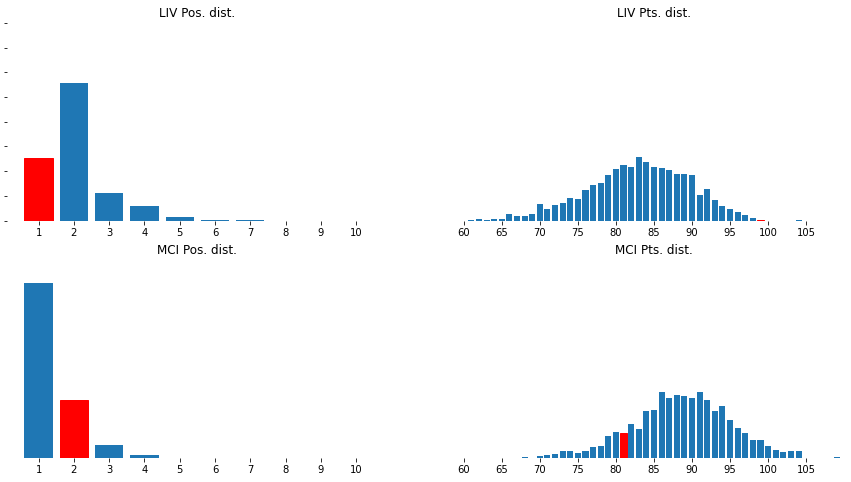

In [ ]:
teams = ['LIV','MCI']

plt.figure(figsize=(15,8))
team = 'LIV'
ax = plt.subplot(221)
barlist = plt.bar(range(1,11),[sum([(t.loc[team,'Pos']==p)/n_scenarios for t in all_tables_19_20]) for p in range(1,11)])
barlist[actual_table_19_20.loc[team,'Pos']-1].set_color('r')  
plt.xlabel("");plt.ylabel("");plt.title(team+' Pos. dist.',loc='center');plt.yticks(visible=False);plt.xticks(range(1,11));
plt.ylim([0,.80])
ax.spines['left'].set_visible(False);ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);ax.spines['bottom'].set_visible(False)

ax = plt.subplot(222)
p,c = np.unique([t.loc[team,'Pts'] for t in all_tables_19_20],return_counts=True);c=c/n_scenarios
barlist = plt.bar(p,c)
barlist[np.argmin(np.abs(p-actual_table_19_20.loc[team,'Pts']))].set_color('r')  
plt.xlabel("");plt.ylabel("");plt.title(team+' Pts. dist.',loc='center');
plt.yticks([],visible=False);plt.xticks(range(60,110,5));plt.ylim([0,.20]);plt.xlim([60,110])

ax.spines['left'].set_visible(False);ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);ax.spines['bottom'].set_visible(False)


team = 'MCI'
ax = plt.subplot(223)
barlist = plt.bar(range(1,11),[sum([(t.loc[team,'Pos']==p) for t in all_tables_19_20])/n_scenarios for p in range(1,11)])
barlist[actual_table_19_20.loc[team,'Pos']-1].set_color('r')  
plt.xlabel("");plt.ylabel("");plt.title(team+' Pos. dist.',loc='center');plt.yticks([],visible=False);plt.xticks(range(1,11));
plt.ylim([0,.80])
ax.spines['left'].set_visible(False);ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);ax.spines['bottom'].set_visible(False)

ax = plt.subplot(224)
p,c = np.unique([t.loc[team,'Pts'] for t in all_tables_19_20],return_counts=True);c=c/n_scenarios
barlist = plt.bar(p,c)
barlist[np.argmin(np.abs(p-actual_table_19_20.loc[team,'Pts']))].set_color('r')  
plt.title(team+' Pts. dist.',loc='center');plt.yticks([],visible=False);plt.xticks(range(60,110,5));plt.ylim([0,.20]);plt.xlim([60,110])
ax.spines['left'].set_visible(False);ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);ax.spines['bottom'].set_visible(False)


print('Percentage of seasons in which LIV finished 18 or more points ahead of MCI = {}%'.format(np.sum([(t.loc['LIV','Pts']-t.loc['MCI','Pts'])>=18 for t in all_tables_19_20])/n_scenarios*100))


MCI have hugely underperformed their expected points total while LIV have outperformed theirs to an even greater extent. The percentage of simulated seasons in which LIV finish 18 points or more ahead of MCI is just 0.5%.
So what is going on here? 


Let's compare each team's goal scored and conceded to the hypothetical Poisson distribution underlying our simulated seasons.

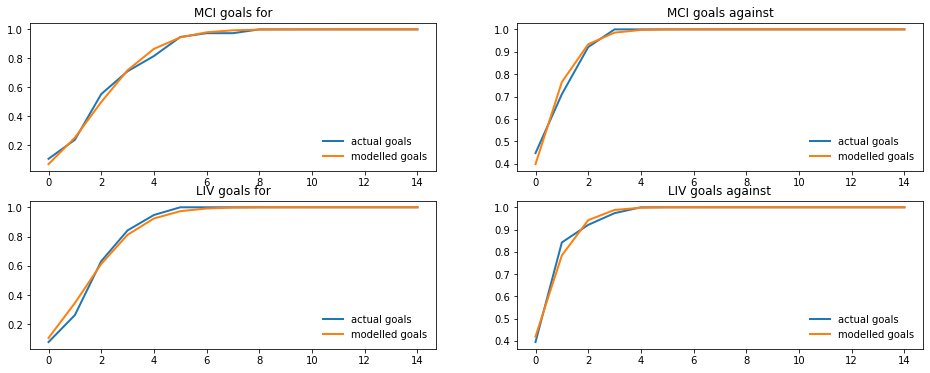

In [ ]:
mci_act_dist_f,mci_act_dist_a,mci_p_dist_f,mci_p_dist_a = calculate_delta_poisson(all_matches_19_20,'MCI')
liv_act_dist_f,liv_act_dist_a,liv_p_dist_f,liv_p_dist_a = calculate_delta_poisson(all_matches_19_20,'LIV')
mci_delta_f = mci_act_dist_f - mci_p_dist_f;mci_delta_a = mci_act_dist_a - mci_p_dist_a;
liv_delta_f = liv_act_dist_f - liv_p_dist_f;liv_delta_a = liv_act_dist_a - liv_p_dist_a;

x = np.arange(mci_delta_f.shape[0])
plt.figure(figsize=(16,6))
plt.subplot(221)
#plt.bar(x-0.5,np.cumsum(mci_act_dist_f),width=0.4, align='center')
#plt.bar(x,np.cumsum(mci_p_dist_f),width=0.4, align='center')
plt.plot(x,np.cumsum(mci_act_dist_f),linewidth =2)
plt.plot(x,np.cumsum(mci_p_dist_f),linewidth =2)
plt.title('MCI goals for');plt.legend(('actual goals','modelled goals'),frameon=False)
plt.subplot(222)
plt.plot(x,np.cumsum(mci_act_dist_a),linewidth =2)
plt.plot(x,np.cumsum(mci_p_dist_a),linewidth =2)
#plt.bar(x-0.5,np.cumsum(mci_act_dist_a),width=0.4, align='center')
#plt.bar(x,np.cumsum(mci_p_dist_a),width=0.4, align='center')
plt.title('MCI goals against');plt.legend(('actual goals','modelled goals'),frameon=False)

plt.subplot(223)
plt.plot(x,np.cumsum(liv_act_dist_f),linewidth =2)
plt.plot(x,np.cumsum(liv_p_dist_f),linewidth =2)
#plt.bar(x-0.5,np.cumsum(liv_act_dist_f),width=0.4, align='center')
#plt.bar(x,np.cumsum(liv_p_dist_f),width=0.4, align='center')
plt.title('LIV goals for');plt.legend(('actual goals','modelled goals'),frameon=False)
plt.subplot(224)
plt.plot(x,np.cumsum(liv_act_dist_a),linewidth =2)
plt.plot(x,np.cumsum(liv_p_dist_a),linewidth =2)
#plt.bar(x-0.5,np.cumsum(liv_act_dist_a),width=0.4, align='center')
#plt.bar(x,np.cumsum(liv_p_dist_a),width=0.4, align='center')
plt.title('LIV goals against');plt.legend(('actual goals','modelled goals'),frameon=False)

Plotting the deviations from the probability mass function for each number of goals is more instructive.

Text(0.5, 1.0, 'LIV delta goals against')

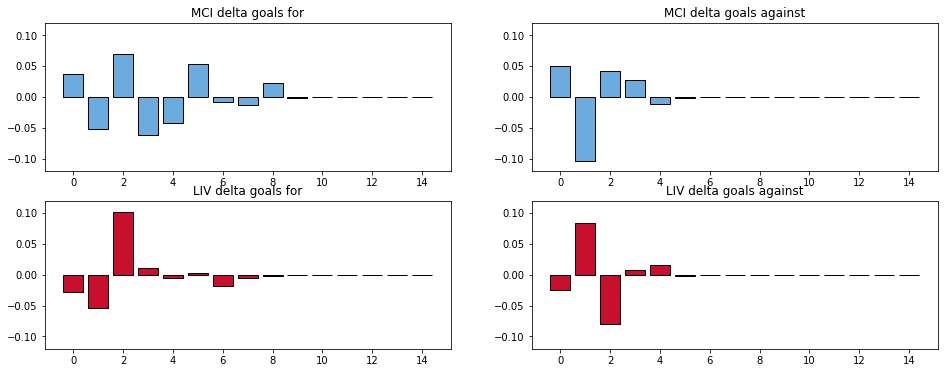

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(221)
plt.bar(range(mci_delta_f.shape[0]),mci_delta_f,edgecolor = "k",linewidth =1, color='#6CABDD')
plt.ylim([-0.12,0.12])
plt.title('MCI delta goals for')
plt.subplot(222)
plt.bar(range(mci_delta_a.shape[0]),mci_delta_a,edgecolor = "k",linewidth =1, color='#6CABDD')
plt.ylim([-0.12,0.12])
plt.title('MCI delta goals against')
plt.subplot(223)
plt.bar(range(liv_delta_f.shape[0]),liv_delta_f,edgecolor = "k",linewidth =1, color='#C8102E')
plt.ylim([-0.12,0.12])
plt.title('LIV delta goals for')
plt.subplot(224)
plt.bar(range(liv_delta_a.shape[0]),liv_delta_a,edgecolor = "k",linewidth =1, color='#C8102E')
plt.ylim([-0.12,0.12])
plt.title('LIV delta goals against')

A picture begins to emerge now. Compared to a Poisson distribution, LIV score 0 or 1 goals less often than they should be they score 2 goals far more often. And on goals conceded the picture is reversed - they concede exactly 1 goal more often and concede 2 less often. The benefits to this distribution are clear - 1-1 draws and 2-2 draws are converted to 2-1 wins. 

For MCI the picture is more mixed - the concede 0 goals more often and 1 goal less often that they should which is positive. However they concede 2 and 3 goals more often. On the scoring side, the fact that they score 5 and 8 goals more often than they should is of little benefit in term of points earned.

[]

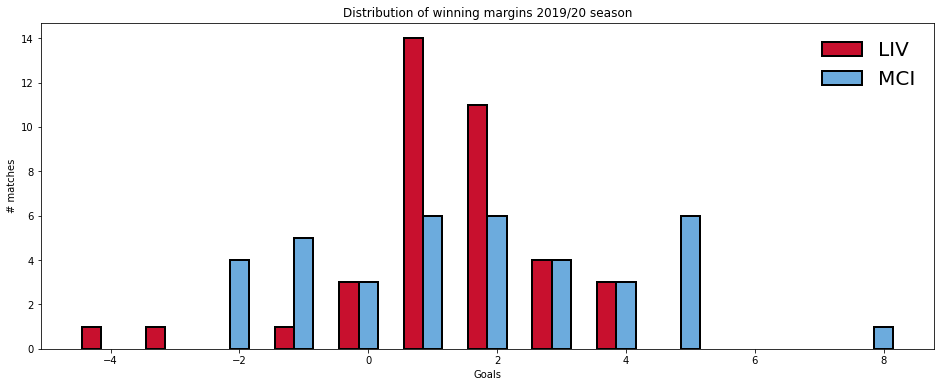

In [ ]:
MCI_results = []
for m in pl_matches_19_20_df.loc[pl_matches_19_20_df.home_team_short_name=='MCI',:].iterrows():
  MCI_results.append([m[1].home_team_goal,m[1].away_team_goal])
                     
for m in pl_matches_19_20_df.loc[pl_matches_19_20_df.away_team_short_name=='MCI',:].iterrows():
  MCI_results.append([m[1].away_team_goal,m[1].home_team_goal])
MCI_margin = [r[0]-r[1] for r in MCI_results]

LIV_results = []
for m in pl_matches_19_20_df.loc[pl_matches_19_20_df.home_team_short_name=='LIV',:].iterrows():
  LIV_results.append([m[1].home_team_goal,m[1].away_team_goal])
                     
for m in pl_matches_19_20_df.loc[pl_matches_19_20_df.away_team_short_name=='LIV',:].iterrows():
  LIV_results.append([m[1].away_team_goal,m[1].home_team_goal])
LIV_margin = [r[0]-r[1] for r in LIV_results]

LIV_m,LIV_c = np.unique(np.array(LIV_margin),return_counts=True)
MCI_m,MCI_c = np.unique(np.array(MCI_margin),return_counts=True)
x = np.arange(min(np.min(LIV_m),np.min(MCI_m)),max(np.max(LIV_m),np.max(MCI_m))+1)

plt.figure(figsize=(16,6))
plt.bar(LIV_m-0.3,LIV_c,width=0.3, align='center',edgecolor = "k",linewidth =2,color= '#C8102E')
plt.bar(MCI_m,MCI_c,width=0.3, align='center',edgecolor = "k",linewidth =2,color='#6CABDD')
plt.legend(('LIV','MCI'),frameon=False,prop={'size': 20})
#plt.bar(x,np.cumsum(liv_p_dist_f),width=0.4, align='center')
plt.xlabel('Goals')
plt.ylabel('# matches')
plt.title('Distribution of winning margins 2019/20 season')
plt.plot()


Both teams drew the same number of games (3). LIV won 25 games by a margin of 1 or 2 goals. MCI's achievement of winning 7 games by 5 or more goals (a feat which LIV never managed) unfortunately is only of benefit to their goal difference. The 2 worst defeats suffered by either team (0-3 and 0-4) were both sufferd by LIV - in fact over 20% of their goals conceded were in these 2 matches.

LIV demonstrated a far greater *efficiency* in the scoring and conceding of goals. All goals are not created equal - the last goal in a 8-0 victory has far lower marginal utility than a winner in a 2-1 or 1-0 win.

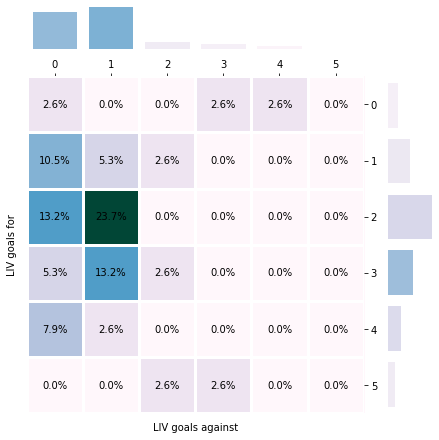

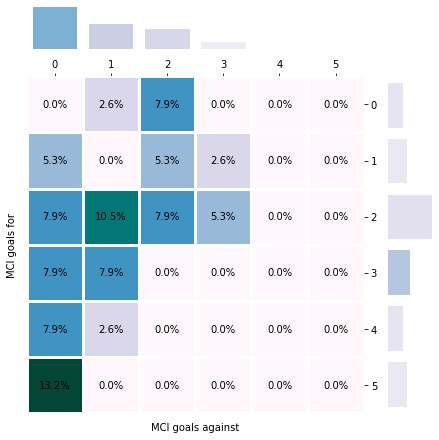

In [ ]:
max_goals=5
liv_results_mat = np.zeros([max_goals+1,max_goals+1])
mci_results_mat = np.zeros([max_goals+1,max_goals+1])
liv_for_hist = []
liv_ag_hist = []
mci_for_hist = []
mci_ag_hist = []

for i in range(max_goals+1):
  liv_for_hist.append(np.sum([l[0]==i for l in LIV_results])/len(LIV_results))
  liv_ag_hist.append(np.sum([l[1]==i for l in LIV_results])/len(LIV_results))
  mci_for_hist.append(np.sum([l[0]==i for l in MCI_results])/len(LIV_results))
  mci_ag_hist.append(np.sum([l[1]==i for l in MCI_results])/len(LIV_results))
  for j in range(max_goals+1):
    liv_results_mat[i,j] = np.sum([r==[i,j] for r in LIV_results])/len(LIV_results)
    mci_results_mat[i,j] = np.sum([r==[i,j] for r in MCI_results])/len(LIV_results)

heatmap_with_histograms(liv_results_mat,np.array(liv_ag_hist),np.array(liv_for_hist),'PuBuGn','LIV goals against','LIV goals for')
heatmap_with_histograms(mci_results_mat,np.array(mci_ag_hist),np.array(mci_for_hist),'PuBuGn','MCI goals against','MCI goals for')